<a href="https://colab.research.google.com/github/aeneuro1993/My-new-page/blob/main/CNN_classificator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Thu Sep 19 20:29:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [3]:
ls {HOME}

drive/  sample_data/


In [4]:
!pip install ultralytics

from IPython import display
display.clear_output()
from IPython.display import display, Image

import ultralytics
ultralytics.checks()
from ultralytics import YOLO

Ultralytics YOLOv8.2.98 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (8 CPUs, 51.0 GB RAM, 32.3/235.7 GB disk)


In [5]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="qMWqT80BKpcsT9nfRXOz")
project = rf.workspace("yellowcode").project("animal-classification-j2npv")
version = project.version(1)
dataset = version.download("folder")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 458.4 kB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to animal-classification-1 in folder:: 100%|██████████| 1060/1060 [00:00<00:00, 4269.70it/s]


In [6]:
!pip install torch torchvision torchaudio

In [7]:
import torch
import torch.nn as nn
import torchvision .models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as optim

from tqdm import tqdm
import random
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from PIL import Image

%matplotlib inline

In [8]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [9]:
plt.style.use('ggplot')

In [10]:
seed=42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [11]:
device=torch.device ('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [12]:
model =models.resnet18(pretrained=True)
model(torch.randn(1,3,224,224)).shape



The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 128MB/s]


torch.Size([1, 1000])

In [13]:
model= models.resnet18(pretrained=True)
num_classes=5
model.fc=nn.Linear(model.fc.in_features,num_classes)


In [14]:
model(torch.randn(1,3,224,224))

tensor([[ 0.2486,  0.0016,  0.4832, -0.0888,  0.5647]], grad_fn=<AddmmBackward0>)

In [16]:
train_data_dir= '/content/animal-classification-1/train'
val_data_dir='/content/animal-classification-1/val'

train_transforms=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

val_transforms=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

train_dataset = ImageFolder(train_data_dir, transform=train_transforms)
val_dataset = ImageFolder(val_data_dir, transform=val_transforms)

In [17]:
train_dataset[610]

(tensor([[[0.9412, 0.9451, 0.9451,  ..., 0.4392, 0.4824, 0.3725],
          [0.9451, 0.9451, 0.9451,  ..., 0.3686, 0.3922, 0.3922],
          [0.9294, 0.9294, 0.9373,  ..., 0.4118, 0.3255, 0.3255],
          ...,
          [0.5373, 0.5569, 0.6353,  ..., 0.6784, 0.7333, 0.8000],
          [0.5882, 0.5882, 0.6275,  ..., 0.6980, 0.7333, 0.7882],
          [0.5882, 0.5961, 0.6118,  ..., 0.6549, 0.7255, 0.7608]],
 
         [[0.9412, 0.9451, 0.9451,  ..., 0.4392, 0.4824, 0.3725],
          [0.9451, 0.9451, 0.9451,  ..., 0.3686, 0.3922, 0.3922],
          [0.9294, 0.9294, 0.9373,  ..., 0.4118, 0.3255, 0.3255],
          ...,
          [0.5373, 0.5569, 0.6353,  ..., 0.6784, 0.7333, 0.8000],
          [0.5882, 0.5882, 0.6275,  ..., 0.6980, 0.7333, 0.7882],
          [0.5882, 0.5961, 0.6118,  ..., 0.6549, 0.7255, 0.7608]],
 
         [[0.9412, 0.9451, 0.9451,  ..., 0.4392, 0.4824, 0.3725],
          [0.9451, 0.9451, 0.9451,  ..., 0.3686, 0.3922, 0.3922],
          [0.9294, 0.9294, 0.9373,  ...,

In [18]:
classes_list=train_dataset.classes
print(classes_list)

['bears', 'cats', 'crows', 'elephants', 'rats']


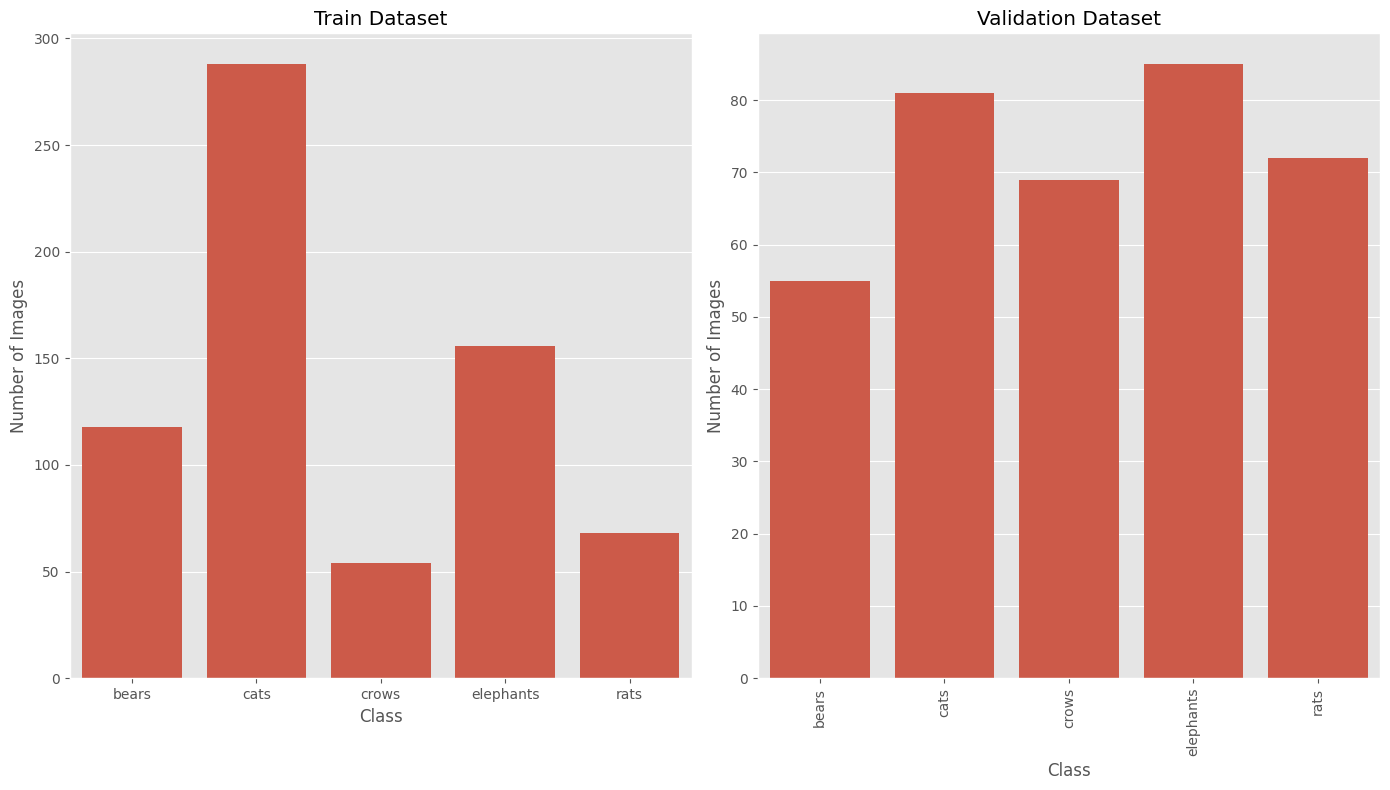

In [19]:
train_class_counts=np.zeros(len(train_dataset.classes))
for _, label in train_dataset:
  train_class_counts[label]+=1

val_class_counts=np.zeros(len(val_dataset.classes))
for _, label in val_dataset:
  val_class_counts[label]+=1

fig,ax=plt.subplots(1,2, figsize = (14,8))

sns.barplot(x=train_dataset.classes, y=train_class_counts, ax=ax[0])
ax[0].set_title('Train Dataset')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Number of Images')

sns.barplot(x=val_dataset.classes, y=val_class_counts, ax=ax[1])
ax[1].set_title('Validation Dataset')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Number of Images')
ax[1].tick_params(axis='x',rotation=90)

plt.tight_layout()
plt.show()


In [20]:
batch_size=64
train_loader=DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader=DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

Normalization

img without normalization


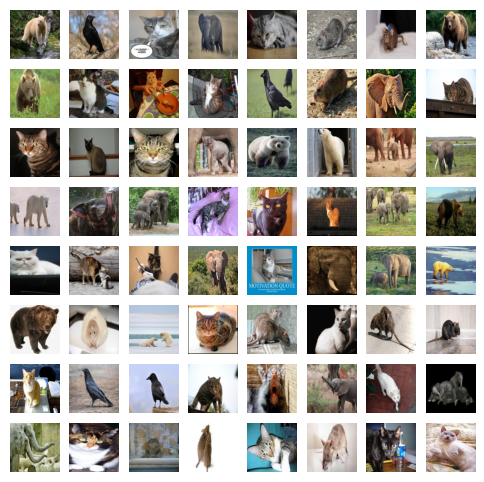

img with normalization


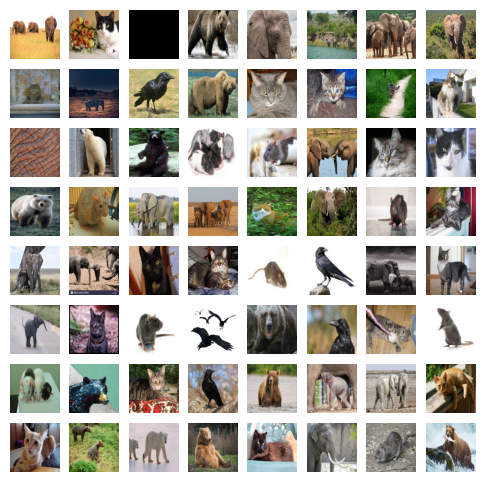

In [21]:
def show_images (images, denormalaize =False):
  if denormalaize:
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = images.numpy().transpose((0,2,3,1))
    images = std*images+mean
    images=np.clip(images, 0,1)
  else:
    images=images.numpy().transpose((0,2,3,1))
  fig,axes = plt.subplots (8,8, figsize = (6,6))
  for i,ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.axis('off')
  plt.show()

images, _=next(iter(train_loader))
print('img without normalization')
show_images(images, denormalaize= False)

images, _=next(iter(train_loader))
print('img with normalization')
show_images(images, denormalaize= False)

Number of batches

In [22]:
len(train_loader), len(val_loader)

(11, 6)

In [23]:
train_dataset[0]

(tensor([[[0.5451, 0.5922, 0.6824,  ..., 0.6824, 0.6706, 0.6588],
          [0.5294, 0.6000, 0.6549,  ..., 0.6784, 0.6667, 0.6549],
          [0.5333, 0.5216, 0.5647,  ..., 0.6745, 0.6627, 0.6510],
          ...,
          [0.4863, 0.5373, 0.7216,  ..., 0.3686, 0.3843, 0.3922],
          [0.5373, 0.5961, 0.7333,  ..., 0.4000, 0.4157, 0.4235],
          [0.6000, 0.6314, 0.7176,  ..., 0.4235, 0.4392, 0.4510]],
 
         [[0.4863, 0.5333, 0.6196,  ..., 0.6157, 0.6039, 0.5922],
          [0.4667, 0.5412, 0.5961,  ..., 0.6118, 0.6000, 0.5882],
          [0.4745, 0.4667, 0.5059,  ..., 0.6078, 0.5961, 0.5843],
          ...,
          [0.3608, 0.4157, 0.6157,  ..., 0.3490, 0.3647, 0.3725],
          [0.4000, 0.4667, 0.6196,  ..., 0.3804, 0.3961, 0.4039],
          [0.4588, 0.4980, 0.6000,  ..., 0.4039, 0.4196, 0.4314]],
 
         [[0.3412, 0.3451, 0.3686,  ..., 0.5451, 0.5412, 0.5294],
          [0.3333, 0.3608, 0.3529,  ..., 0.5412, 0.5373, 0.5255],
          [0.3608, 0.3098, 0.2863,  ...,

In [24]:
next(iter(train_loader))[1]

tensor([1, 1, 3, 3, 1, 0, 4, 3, 4, 1, 4, 3, 4, 1, 3, 4, 1, 4, 3, 0, 0, 4, 4, 1, 1, 2, 2, 4, 3, 0, 0, 0, 1, 3, 1, 0, 1, 0, 1, 1, 3, 1, 1, 3, 0, 3, 1, 3, 3, 1, 3, 4, 0, 0, 1, 4, 1, 3, 3, 4, 1, 3, 3, 0])

Model validation

In [25]:
model.eval()
model.to(device)
correct=0
total=0
with torch.no_grad():
  for images, labels in tqdm(val_loader):
    images, labels=images.to(device), labels.to(device)
    outputs=model(images)
    print(outputs.shape)
    _, predicted=outputs.max(1)
    print(predicted)
    print(predicted)
    total+=labels.size(0)
    correct+=predicted.eq(labels).sum().item()
val_accuracy=correct/total
print(val_accuracy)

 17%|█▋        | 1/6 [00:01<00:07,  1.52s/it]

torch.Size([64, 5])
tensor([4, 4, 4, 2, 4, 4, 4, 1, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 0, 4, 2, 4, 4, 4, 4, 4, 0, 0, 4, 0, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 1, 0, 4], device='cuda:0')
tensor([4, 4, 4, 2, 4, 4, 4, 1, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 0, 4, 2, 4, 4, 4, 4, 4, 0, 0, 4, 0, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 1, 0, 4], device='cuda:0')


 33%|███▎      | 2/6 [00:02<00:03,  1.08it/s]

torch.Size([64, 5])
tensor([4, 4, 1, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 2, 4, 1, 0, 4, 2, 0, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 1, 1, 4, 4, 0, 4, 4, 4, 4, 0, 4, 2, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], device='cuda:0')
tensor([4, 4, 1, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 2, 4, 1, 0, 4, 2, 0, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 1, 1, 4, 4, 0, 4, 4, 4, 4, 0, 4, 2, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], device='cuda:0')


 50%|█████     | 3/6 [00:02<00:02,  1.33it/s]

torch.Size([64, 5])
tensor([4, 4, 4, 4, 4, 2, 4, 2, 4, 4, 2, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 0, 4, 0, 1, 4, 2, 4, 4, 4, 4, 4, 4, 0, 1, 4, 4, 4, 4, 4, 4, 1, 4, 4, 1, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 1, 4, 4, 4], device='cuda:0')
tensor([4, 4, 4, 4, 4, 2, 4, 2, 4, 4, 2, 4, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 0, 4, 0, 1, 4, 2, 4, 4, 4, 4, 4, 4, 0, 1, 4, 4, 4, 4, 4, 4, 1, 4, 4, 1, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 1, 4, 4, 4], device='cuda:0')


 67%|██████▋   | 4/6 [00:03<00:01,  1.50it/s]

torch.Size([64, 5])
tensor([4, 2, 4, 1, 0, 4, 4, 4, 4, 2, 0, 4, 4, 1, 4, 1, 4, 4, 4, 4, 4, 4, 0, 4, 1, 0, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 2, 0, 4, 4, 0, 0, 2, 2, 4, 4, 2, 4, 4, 4, 4, 1, 4, 4, 4, 0, 4, 0, 4, 4, 4, 4, 1, 4], device='cuda:0')
tensor([4, 2, 4, 1, 0, 4, 4, 4, 4, 2, 0, 4, 4, 1, 4, 1, 4, 4, 4, 4, 4, 4, 0, 4, 1, 0, 4, 4, 4, 4, 4, 1, 4, 4, 4, 4, 2, 0, 4, 4, 0, 0, 2, 2, 4, 4, 2, 4, 4, 4, 4, 1, 4, 4, 4, 0, 4, 0, 4, 4, 4, 4, 1, 4], device='cuda:0')


 83%|████████▎ | 5/6 [00:03<00:00,  1.63it/s]

torch.Size([64, 5])
tensor([4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 1, 4, 4, 4, 4, 0, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 1, 0, 4, 4, 4, 1, 4, 4, 4, 4, 1, 4, 4, 4, 3, 4], device='cuda:0')
tensor([4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 1, 4, 4, 4, 4, 0, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 1, 0, 4, 4, 4, 1, 4, 4, 4, 4, 1, 4, 4, 4, 3, 4], device='cuda:0')


100%|██████████| 6/6 [00:03<00:00,  1.50it/s]

torch.Size([42, 5])
tensor([2, 4, 4, 1, 4, 2, 4, 1, 1, 4, 4, 4, 0, 4, 4, 0, 4, 0, 4, 4, 4, 1, 4, 4, 4, 1, 4, 1, 0, 4, 0, 4, 4, 4, 4, 3, 4, 4, 4, 1, 4, 4], device='cuda:0')
tensor([2, 4, 4, 1, 4, 2, 4, 1, 1, 4, 4, 4, 0, 4, 4, 0, 4, 0, 4, 4, 4, 1, 4, 4, 4, 1, 4, 1, 0, 4, 0, 4, 4, 4, 4, 3, 4, 4, 4, 1, 4, 4], device='cuda:0')
0.2513812154696133


In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

num_epochs =70

train_losses=[]
val_losses=[]
train_accuracies=[]
val_accuracies=[]
best_val_accuracy=0
model.to(device)

for epoch in range(num_epochs):
  model.train()
  running_loss=0.0
  correct=0
  total=0
  for images, labels in tqdm(train_loader):
    images, labels=images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs=model(images)
    loss=criterion(outputs,labels)
    loss.backward()
    optimizer.step()

    running_loss+=loss.item()
    _, predicted=outputs.max(1)
    total+=labels.size(0)
    correct+=predicted.eq(labels).sum().item()

  train_loss=running_loss / len(train_loader)
  train_accuracy=correct / total
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)

  model.eval()
  val_loss=0.0
  correct=0
  total=0
  with torch.no_grad():
     for images, labels in tqdm(val_loader):
         images, labels=images.to(device), labels.to(device)
         outputs=model(images)
         loss=criterion(outputs, labels)

         val_loss+=loss.item()
         _,predicted=outputs.max(1)
         total+=labels.size(0)
         correct+=predicted.eq(labels).sum().item()

  val_loss/=len(val_loader)
  val_accuracy=correct / total
  val_losses.append(val_loss)
  val_accuracies.append(val_accuracy)

  print(f'Epoch [{epoch+1}/{num_epochs}],'
        f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f},'
        f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

 # Inside the training loop, save the model based on the best validation accuracy
  if val_accuracy > best_val_accuracy:
    best_val_accuracy = val_accuracy
    torch.save(model.state_dict(), 'best_model.pth')
    print('Saved best model')

# Save the final model after the loop completes
  torch.save(model.state_dict(), 'final_model.pth')
  print()



100%|██████████| 6/6 [00:02<00:00,  2.30it/s]


Epoch [1/70],Train Loss: 2.1181, Train Accuracy: 0.4064,Val Loss: 243.6661, Val Accuracy: 0.2238
Saved best model



100%|██████████| 6/6 [00:02<00:00,  2.32it/s]


Epoch [2/70],Train Loss: 1.5372, Train Accuracy: 0.4620,Val Loss: 2003.0633, Val Accuracy: 0.2238



100%|██████████| 6/6 [00:02<00:00,  2.24it/s]


Epoch [3/70],Train Loss: 1.3588, Train Accuracy: 0.5205,Val Loss: 2.5500, Val Accuracy: 0.3343
Saved best model



100%|██████████| 6/6 [00:02<00:00,  2.26it/s]


Epoch [4/70],Train Loss: 1.1854, Train Accuracy: 0.5673,Val Loss: 5.1837, Val Accuracy: 0.2845



100%|██████████| 6/6 [00:02<00:00,  2.34it/s]


Epoch [5/70],Train Loss: 1.1605, Train Accuracy: 0.5848,Val Loss: 2.1710, Val Accuracy: 0.3398
Saved best model



100%|██████████| 6/6 [00:02<00:00,  2.34it/s]


Epoch [6/70],Train Loss: 1.1382, Train Accuracy: 0.5819,Val Loss: 1.6828, Val Accuracy: 0.3674
Saved best model



100%|██████████| 6/6 [00:02<00:00,  2.37it/s]


Epoch [7/70],Train Loss: 1.0330, Train Accuracy: 0.6067,Val Loss: 1.6436, Val Accuracy: 0.3260



100%|██████████| 6/6 [00:02<00:00,  2.24it/s]


Epoch [8/70],Train Loss: 0.9489, Train Accuracy: 0.6520,Val Loss: 2.3554, Val Accuracy: 0.4144
Saved best model



100%|██████████| 6/6 [00:02<00:00,  2.31it/s]


Epoch [9/70],Train Loss: 0.8314, Train Accuracy: 0.6886,Val Loss: 1.7788, Val Accuracy: 0.4503
Saved best model



100%|██████████| 6/6 [00:02<00:00,  2.30it/s]


Epoch [10/70],Train Loss: 0.7425, Train Accuracy: 0.7368,Val Loss: 2.2295, Val Accuracy: 0.4309



100%|██████████| 6/6 [00:02<00:00,  2.32it/s]


Epoch [11/70],Train Loss: 0.8223, Train Accuracy: 0.7164,Val Loss: 2.1575, Val Accuracy: 0.3149



100%|██████████| 6/6 [00:02<00:00,  2.35it/s]


Epoch [12/70],Train Loss: 0.7522, Train Accuracy: 0.7208,Val Loss: 1.8581, Val Accuracy: 0.4669
Saved best model



100%|██████████| 6/6 [00:02<00:00,  2.22it/s]


Epoch [13/70],Train Loss: 0.5984, Train Accuracy: 0.7763,Val Loss: 2.6327, Val Accuracy: 0.3895



100%|██████████| 6/6 [00:02<00:00,  2.26it/s]


Epoch [14/70],Train Loss: 0.6029, Train Accuracy: 0.7822,Val Loss: 3.2445, Val Accuracy: 0.2624



100%|██████████| 6/6 [00:02<00:00,  2.28it/s]


Epoch [15/70],Train Loss: 0.6814, Train Accuracy: 0.7602,Val Loss: 2.3751, Val Accuracy: 0.4006



100%|██████████| 6/6 [00:02<00:00,  2.26it/s]


Epoch [16/70],Train Loss: 0.6850, Train Accuracy: 0.7456,Val Loss: 1.6240, Val Accuracy: 0.5470
Saved best model



100%|██████████| 6/6 [00:02<00:00,  2.23it/s]


Epoch [17/70],Train Loss: 0.5755, Train Accuracy: 0.7909,Val Loss: 3.9228, Val Accuracy: 0.4088



100%|██████████| 6/6 [00:02<00:00,  2.26it/s]


Epoch [18/70],Train Loss: 0.4721, Train Accuracy: 0.8421,Val Loss: 2.3474, Val Accuracy: 0.5276



100%|██████████| 6/6 [00:02<00:00,  2.28it/s]


Epoch [19/70],Train Loss: 0.4795, Train Accuracy: 0.8275,Val Loss: 1.9223, Val Accuracy: 0.5193



100%|██████████| 6/6 [00:02<00:00,  2.27it/s]


Epoch [20/70],Train Loss: 0.5147, Train Accuracy: 0.8304,Val Loss: 14.0966, Val Accuracy: 0.2901



100%|██████████| 6/6 [00:02<00:00,  2.30it/s]


Epoch [21/70],Train Loss: 0.4287, Train Accuracy: 0.8392,Val Loss: 1.4541, Val Accuracy: 0.5967
Saved best model



100%|██████████| 6/6 [00:02<00:00,  2.23it/s]


Epoch [22/70],Train Loss: 0.3105, Train Accuracy: 0.8977,Val Loss: 1.3424, Val Accuracy: 0.6381
Saved best model



100%|██████████| 6/6 [00:02<00:00,  2.29it/s]


Epoch [23/70],Train Loss: 0.3202, Train Accuracy: 0.9006,Val Loss: 4.2701, Val Accuracy: 0.2983



100%|██████████| 6/6 [00:02<00:00,  2.22it/s]


Epoch [24/70],Train Loss: 0.2956, Train Accuracy: 0.9035,Val Loss: 3.7070, Val Accuracy: 0.5028



100%|██████████| 6/6 [00:02<00:00,  2.22it/s]


Epoch [25/70],Train Loss: 0.3798, Train Accuracy: 0.8582,Val Loss: 2.2979, Val Accuracy: 0.5000



100%|██████████| 6/6 [00:02<00:00,  2.23it/s]


Epoch [26/70],Train Loss: 0.2893, Train Accuracy: 0.9006,Val Loss: 2.4445, Val Accuracy: 0.5525



100%|██████████| 6/6 [00:02<00:00,  2.20it/s]


Epoch [27/70],Train Loss: 0.2635, Train Accuracy: 0.9137,Val Loss: 3.7932, Val Accuracy: 0.4448



100%|██████████| 6/6 [00:02<00:00,  2.15it/s]


Epoch [28/70],Train Loss: 0.2420, Train Accuracy: 0.9167,Val Loss: 3.9757, Val Accuracy: 0.4309



100%|██████████| 6/6 [00:02<00:00,  2.20it/s]


Epoch [29/70],Train Loss: 0.1922, Train Accuracy: 0.9298,Val Loss: 1.4657, Val Accuracy: 0.6326



100%|██████████| 6/6 [00:02<00:00,  2.16it/s]


Epoch [30/70],Train Loss: 0.1592, Train Accuracy: 0.9459,Val Loss: 1.7066, Val Accuracy: 0.5856



100%|██████████| 6/6 [00:02<00:00,  2.19it/s]


Epoch [31/70],Train Loss: 0.2038, Train Accuracy: 0.9386,Val Loss: 3.4018, Val Accuracy: 0.4503



100%|██████████| 6/6 [00:02<00:00,  2.21it/s]


Epoch [32/70],Train Loss: 0.1983, Train Accuracy: 0.9342,Val Loss: 4.6198, Val Accuracy: 0.4033



100%|██████████| 6/6 [00:02<00:00,  2.23it/s]


Epoch [33/70],Train Loss: 0.1764, Train Accuracy: 0.9430,Val Loss: 1.9110, Val Accuracy: 0.5884



100%|██████████| 6/6 [00:02<00:00,  2.21it/s]


Epoch [34/70],Train Loss: 0.1477, Train Accuracy: 0.9488,Val Loss: 1.9379, Val Accuracy: 0.6575
Saved best model



100%|██████████| 6/6 [00:02<00:00,  2.25it/s]


Epoch [35/70],Train Loss: 0.0969, Train Accuracy: 0.9678,Val Loss: 2.5403, Val Accuracy: 0.4972



100%|██████████| 6/6 [00:02<00:00,  2.23it/s]


Epoch [36/70],Train Loss: 0.0989, Train Accuracy: 0.9708,Val Loss: 1.3743, Val Accuracy: 0.7017
Saved best model



100%|██████████| 6/6 [00:02<00:00,  2.19it/s]


Epoch [37/70],Train Loss: 0.0893, Train Accuracy: 0.9708,Val Loss: 4.5199, Val Accuracy: 0.5000



100%|██████████| 6/6 [00:02<00:00,  2.24it/s]


Epoch [38/70],Train Loss: 0.0741, Train Accuracy: 0.9781,Val Loss: 1.2619, Val Accuracy: 0.6740



100%|██████████| 6/6 [00:02<00:00,  2.06it/s]


Epoch [39/70],Train Loss: 0.0827, Train Accuracy: 0.9751,Val Loss: 1.5744, Val Accuracy: 0.6851



100%|██████████| 6/6 [00:02<00:00,  2.18it/s]


Epoch [40/70],Train Loss: 0.0671, Train Accuracy: 0.9737,Val Loss: 5.6181, Val Accuracy: 0.3343



100%|██████████| 6/6 [00:02<00:00,  2.24it/s]


Epoch [41/70],Train Loss: 0.0699, Train Accuracy: 0.9751,Val Loss: 2.5437, Val Accuracy: 0.5304



100%|██████████| 6/6 [00:02<00:00,  2.04it/s]


Epoch [42/70],Train Loss: 0.0753, Train Accuracy: 0.9839,Val Loss: 2.4368, Val Accuracy: 0.6243



100%|██████████| 6/6 [00:02<00:00,  2.25it/s]


Epoch [43/70],Train Loss: 0.1118, Train Accuracy: 0.9635,Val Loss: 1.1886, Val Accuracy: 0.7514
Saved best model



100%|██████████| 6/6 [00:02<00:00,  2.28it/s]


Epoch [44/70],Train Loss: 0.1098, Train Accuracy: 0.9649,Val Loss: 1.2460, Val Accuracy: 0.6989



100%|██████████| 6/6 [00:02<00:00,  2.27it/s]


Epoch [45/70],Train Loss: 0.1147, Train Accuracy: 0.9664,Val Loss: 2.0919, Val Accuracy: 0.6243



100%|██████████| 6/6 [00:02<00:00,  2.18it/s]


Epoch [46/70],Train Loss: 0.1243, Train Accuracy: 0.9635,Val Loss: 3.5321, Val Accuracy: 0.5442



100%|██████████| 6/6 [00:02<00:00,  2.26it/s]


Epoch [47/70],Train Loss: 0.1074, Train Accuracy: 0.9664,Val Loss: 2.4453, Val Accuracy: 0.5912



100%|██████████| 6/6 [00:02<00:00,  2.20it/s]


Epoch [48/70],Train Loss: 0.1781, Train Accuracy: 0.9371,Val Loss: 3.3682, Val Accuracy: 0.2845



100%|██████████| 6/6 [00:02<00:00,  2.25it/s]


Epoch [49/70],Train Loss: 0.1488, Train Accuracy: 0.9401,Val Loss: 3.4264, Val Accuracy: 0.4696



100%|██████████| 6/6 [00:02<00:00,  2.25it/s]


Epoch [50/70],Train Loss: 0.0931, Train Accuracy: 0.9708,Val Loss: 3.3721, Val Accuracy: 0.5028



100%|██████████| 6/6 [00:02<00:00,  2.22it/s]


Epoch [51/70],Train Loss: 0.0728, Train Accuracy: 0.9795,Val Loss: 2.4872, Val Accuracy: 0.5718



100%|██████████| 6/6 [00:02<00:00,  2.32it/s]


Epoch [52/70],Train Loss: 0.0574, Train Accuracy: 0.9825,Val Loss: 3.6380, Val Accuracy: 0.5166



100%|██████████| 6/6 [00:02<00:00,  2.29it/s]


Epoch [53/70],Train Loss: 0.0381, Train Accuracy: 0.9883,Val Loss: 1.4540, Val Accuracy: 0.7099



100%|██████████| 6/6 [00:02<00:00,  2.32it/s]


Epoch [54/70],Train Loss: 0.0464, Train Accuracy: 0.9883,Val Loss: 1.3377, Val Accuracy: 0.7099



100%|██████████| 6/6 [00:02<00:00,  2.24it/s]


Epoch [55/70],Train Loss: 0.0298, Train Accuracy: 0.9927,Val Loss: 1.5049, Val Accuracy: 0.7127



100%|██████████| 6/6 [00:02<00:00,  2.27it/s]


Epoch [56/70],Train Loss: 0.0325, Train Accuracy: 0.9883,Val Loss: 2.0166, Val Accuracy: 0.6685



100%|██████████| 6/6 [00:02<00:00,  2.27it/s]


Epoch [57/70],Train Loss: 0.0481, Train Accuracy: 0.9825,Val Loss: 2.4670, Val Accuracy: 0.5939



100%|██████████| 6/6 [00:02<00:00,  2.31it/s]


Epoch [58/70],Train Loss: 0.0451, Train Accuracy: 0.9825,Val Loss: 3.9498, Val Accuracy: 0.5359



100%|██████████| 6/6 [00:02<00:00,  2.31it/s]


Epoch [59/70],Train Loss: 0.0311, Train Accuracy: 0.9912,Val Loss: 5.5181, Val Accuracy: 0.4365



100%|██████████| 6/6 [00:03<00:00,  1.93it/s]


Epoch [60/70],Train Loss: 0.0427, Train Accuracy: 0.9810,Val Loss: 1.3533, Val Accuracy: 0.7265



100%|██████████| 6/6 [00:02<00:00,  2.35it/s]


Epoch [61/70],Train Loss: 0.0308, Train Accuracy: 0.9868,Val Loss: 3.8862, Val Accuracy: 0.4834



100%|██████████| 6/6 [00:02<00:00,  2.34it/s]


Epoch [62/70],Train Loss: 0.0637, Train Accuracy: 0.9825,Val Loss: 1.6537, Val Accuracy: 0.7044



100%|██████████| 6/6 [00:02<00:00,  2.31it/s]


Epoch [63/70],Train Loss: 0.0636, Train Accuracy: 0.9854,Val Loss: 1.3954, Val Accuracy: 0.7403



100%|██████████| 6/6 [00:02<00:00,  2.32it/s]


Epoch [64/70],Train Loss: 0.0340, Train Accuracy: 0.9883,Val Loss: 2.7848, Val Accuracy: 0.6354



100%|██████████| 6/6 [00:02<00:00,  2.30it/s]


Epoch [65/70],Train Loss: 0.0190, Train Accuracy: 0.9927,Val Loss: 1.2302, Val Accuracy: 0.7762
Saved best model



100%|██████████| 6/6 [00:02<00:00,  2.30it/s]


Epoch [66/70],Train Loss: 0.0175, Train Accuracy: 0.9956,Val Loss: 1.7049, Val Accuracy: 0.7072



100%|██████████| 6/6 [00:02<00:00,  2.29it/s]


Epoch [67/70],Train Loss: 0.0244, Train Accuracy: 0.9898,Val Loss: 2.0868, Val Accuracy: 0.6796



100%|██████████| 6/6 [00:02<00:00,  2.26it/s]


Epoch [68/70],Train Loss: 0.0507, Train Accuracy: 0.9825,Val Loss: 4.2533, Val Accuracy: 0.5028



100%|██████████| 6/6 [00:02<00:00,  2.28it/s]


Epoch [69/70],Train Loss: 0.0573, Train Accuracy: 0.9795,Val Loss: 3.1968, Val Accuracy: 0.5801



100%|██████████| 6/6 [00:02<00:00,  2.29it/s]

Epoch [70/70],Train Loss: 0.0613, Train Accuracy: 0.9810,Val Loss: 2.8228, Val Accuracy: 0.6050



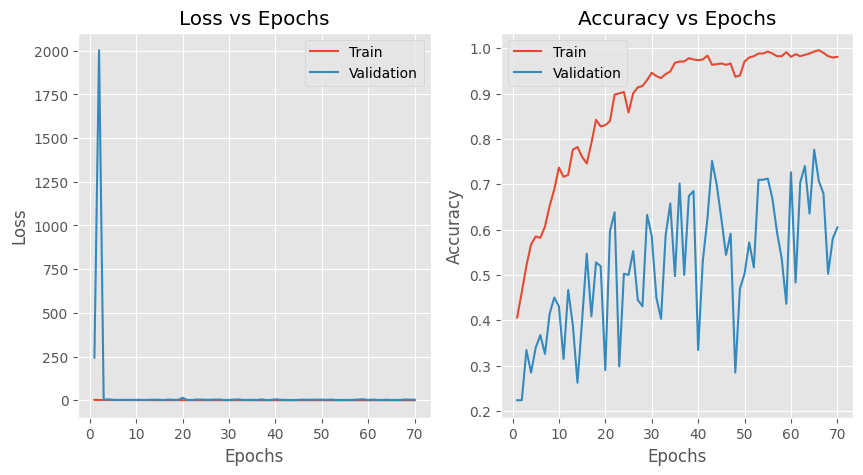

In [27]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()

In [28]:
#Оценка метрик качества для текущих весов модели
def evaluate_model(model, dataloader):
  model.eval()
  y_true=[]
  y_pred=[]
  with torch.no_grad():
    for images, labels in dataloader:
      images, labels=images.to(device), labels.to(device)
      outputs=model(images)
      _, predicted=torch.max(outputs.data, 1)
      y_true.extend(labels.cpu().numpy())
      y_pred.extend(predicted.cpu().numpy())
  cm=confusion_matrix(y_true, y_pred)
  report=classification_report(y_true, y_pred)
  report=classification_report(y_true, y_pred)
  accuracy=np.sum(np.diag(cm))/np.sum(cm)

  weighted_f1=f1_score(y_true, y_pred, average='weighted')

  return cm, report, accuracy, weighted_f1

def plot_confusion_matrix(cm, classes):
  with plt.style.context('default'):
      plt.figure(figsize=(5,4))
      sns.set(font_scale=1.0)
      sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=classes, yticklabels=classes)
      plt.xlabel('Predicted')
      plt.ylabel('True')
      plt.title('Confusion Matrix')
      plt.show()


Metrix for current model:
              precision    recall  f1-score   support

           0       0.64      0.85      0.73        55
           1       0.83      0.73      0.78        81
           2       0.74      0.93      0.82        69
           3       0.92      0.72      0.81        85
           4       0.77      0.69      0.73        72

    accuracy                           0.78       362
   macro avg       0.78      0.78      0.77       362
weighted avg       0.79      0.78      0.78       362

Accuracy: 0.7762


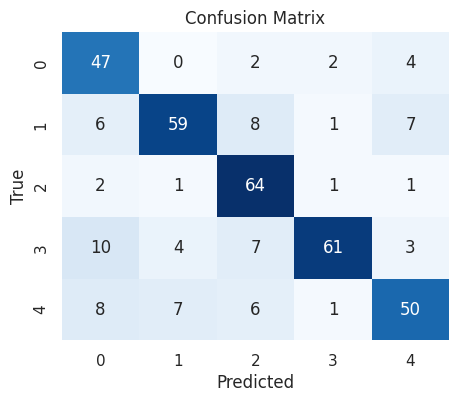

In [29]:
#Веса модели
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)
#Матрица ошибок
cm, report, accuracy_1, weighted_f1_1=evaluate_model(model, val_loader)
print('Metrix for current model:')
print(report)
print(f'Accuracy: {accuracy_1:.4f}')
plot_confusion_matrix(cm, classes=list(range(5)))

#Augmentation

In [39]:
import torch.nn as nn
import torchvision.models as models

# Load pre-trained ResNet-18 model
model = models.resnet18(weights=True)

# Number of output classes
num_classes = 5

# Replace the final fully connected layer to match the number of classes
model.fc = nn.Linear(model.fc.in_features, num_classes)


In [40]:
train_data_dir= '/content/animal-classification-1/train'
val_data_dir='/content/animal-classification-1/val'

train_transforms=transforms.Compose([
    transforms.Resize(256),
    transforms.RandomRotation(40),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms=transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(train_data_dir, transform=train_transforms)
val_dataset = ImageFolder(val_data_dir, transform=val_transforms)

batch_size=64
train_loader=DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader=DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


img without augmentation:


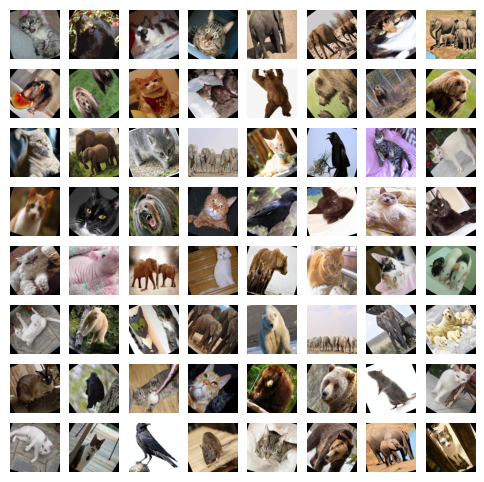

In [41]:
images,_ = next(iter(train_loader))
print('img without augmentation:')
show_images(images, denormalaize= True)


In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs =70

train_losses=[]
val_losses=[]
train_accuracies=[]
val_accuracies=[]
best_val_accuracy=0
model.to(device)

for epoch in range(num_epochs):
  model.train()
  running_loss=0.0
  correct=0
  total=0
  for images, labels in tqdm(train_loader):
    images, labels=images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs=model(images)
    loss=criterion(outputs,labels)
    loss.backward()
    optimizer.step()

    running_loss+=loss.item()
    _, predicted=outputs.max(1)
    total+=labels.size(0)
    correct+=predicted.eq(labels).sum().item()

  train_loss=running_loss / len(train_loader)
  train_accuracy=correct / total
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)

  model.eval()
  val_loss=0.0
  correct=0
  total=0
  with torch.no_grad():
     for images, labels in tqdm(val_loader):
         images, labels=images.to(device), labels.to(device)
         outputs=model(images)
         loss=criterion(outputs, labels)

         val_loss+=loss.item()
         _,predicted=outputs.max(1)
         total+=labels.size(0)
         correct+=predicted.eq(labels).sum().item()

  val_loss/=len(val_loader)
  val_accuracy=correct / total
  val_losses.append(val_loss)
  val_accuracies.append(val_accuracy)

  print(f'Epoch [{epoch+1}/{num_epochs}],'
        f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f},'
        f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

 # Inside the training loop, save the model based on the best validation accuracy
  if val_accuracy > best_val_accuracy:
    best_val_accuracy = val_accuracy
    torch.save(model.state_dict(), 'best_model.pth')
    print('Saved best model')

# Save the final model after the loop completes
  torch.save(model.state_dict(), 'final_model.pth')
  print()



100%|██████████| 6/6 [00:02<00:00,  2.11it/s]


Epoch [1/70],Train Loss: 1.4966, Train Accuracy: 0.3421,Val Loss: 1.5686, Val Accuracy: 0.2762
Saved best model



100%|██████████| 6/6 [00:02<00:00,  2.09it/s]


Epoch [2/70],Train Loss: 1.2089, Train Accuracy: 0.5263,Val Loss: 1.5332, Val Accuracy: 0.3481
Saved best model



100%|██████████| 6/6 [00:02<00:00,  2.13it/s]


Epoch [3/70],Train Loss: 1.0514, Train Accuracy: 0.5921,Val Loss: 1.5321, Val Accuracy: 0.3950
Saved best model



100%|██████████| 6/6 [00:02<00:00,  2.10it/s]


Epoch [4/70],Train Loss: 0.9273, Train Accuracy: 0.6535,Val Loss: 1.3471, Val Accuracy: 0.4834
Saved best model



100%|██████████| 6/6 [00:02<00:00,  2.10it/s]


Epoch [5/70],Train Loss: 0.8343, Train Accuracy: 0.6988,Val Loss: 1.5522, Val Accuracy: 0.4862
Saved best model



100%|██████████| 6/6 [00:02<00:00,  2.06it/s]


Epoch [6/70],Train Loss: 0.7921, Train Accuracy: 0.7076,Val Loss: 1.5262, Val Accuracy: 0.4834



100%|██████████| 6/6 [00:02<00:00,  2.12it/s]


Epoch [7/70],Train Loss: 0.7429, Train Accuracy: 0.7295,Val Loss: 1.3300, Val Accuracy: 0.5608
Saved best model



100%|██████████| 6/6 [00:02<00:00,  2.16it/s]


Epoch [8/70],Train Loss: 0.6893, Train Accuracy: 0.7485,Val Loss: 1.3495, Val Accuracy: 0.5552



100%|██████████| 6/6 [00:02<00:00,  2.14it/s]


Epoch [9/70],Train Loss: 0.6528, Train Accuracy: 0.7471,Val Loss: 1.9149, Val Accuracy: 0.3895



100%|██████████| 6/6 [00:02<00:00,  2.10it/s]


Epoch [10/70],Train Loss: 0.5865, Train Accuracy: 0.7895,Val Loss: 1.4675, Val Accuracy: 0.5635
Saved best model



100%|██████████| 6/6 [00:02<00:00,  2.06it/s]


Epoch [11/70],Train Loss: 0.5088, Train Accuracy: 0.7939,Val Loss: 1.3271, Val Accuracy: 0.5442



100%|██████████| 6/6 [00:02<00:00,  2.09it/s]


Epoch [12/70],Train Loss: 0.4963, Train Accuracy: 0.8041,Val Loss: 1.3937, Val Accuracy: 0.5497



100%|██████████| 6/6 [00:02<00:00,  2.14it/s]


Epoch [13/70],Train Loss: 0.4596, Train Accuracy: 0.8260,Val Loss: 1.4756, Val Accuracy: 0.5967
Saved best model



100%|██████████| 6/6 [00:02<00:00,  2.02it/s]


Epoch [14/70],Train Loss: 0.3720, Train Accuracy: 0.8728,Val Loss: 1.3738, Val Accuracy: 0.5773



100%|██████████| 6/6 [00:02<00:00,  2.09it/s]


Epoch [15/70],Train Loss: 0.3773, Train Accuracy: 0.8640,Val Loss: 1.2715, Val Accuracy: 0.6492
Saved best model



100%|██████████| 6/6 [00:02<00:00,  2.06it/s]


Epoch [16/70],Train Loss: 0.3405, Train Accuracy: 0.8830,Val Loss: 1.6942, Val Accuracy: 0.5304



100%|██████████| 6/6 [00:02<00:00,  2.10it/s]


Epoch [17/70],Train Loss: 0.3205, Train Accuracy: 0.8801,Val Loss: 1.2091, Val Accuracy: 0.6354



100%|██████████| 6/6 [00:02<00:00,  2.09it/s]


Epoch [18/70],Train Loss: 0.3276, Train Accuracy: 0.8772,Val Loss: 1.0260, Val Accuracy: 0.6740
Saved best model



100%|██████████| 6/6 [00:02<00:00,  2.11it/s]


Epoch [19/70],Train Loss: 0.2968, Train Accuracy: 0.8904,Val Loss: 1.2052, Val Accuracy: 0.6160



100%|██████████| 6/6 [00:02<00:00,  2.09it/s]


Epoch [20/70],Train Loss: 0.2847, Train Accuracy: 0.9094,Val Loss: 1.4293, Val Accuracy: 0.6160



100%|██████████| 6/6 [00:02<00:00,  2.14it/s]


Epoch [21/70],Train Loss: 0.2967, Train Accuracy: 0.8947,Val Loss: 1.2745, Val Accuracy: 0.6630



100%|██████████| 6/6 [00:02<00:00,  2.12it/s]


Epoch [22/70],Train Loss: 0.2981, Train Accuracy: 0.8904,Val Loss: 1.2327, Val Accuracy: 0.6492



100%|██████████| 6/6 [00:02<00:00,  2.13it/s]


Epoch [23/70],Train Loss: 0.2318, Train Accuracy: 0.9181,Val Loss: 1.4492, Val Accuracy: 0.6657



100%|██████████| 6/6 [00:02<00:00,  2.09it/s]


Epoch [24/70],Train Loss: 0.2279, Train Accuracy: 0.9196,Val Loss: 1.4120, Val Accuracy: 0.6243



100%|██████████| 6/6 [00:02<00:00,  2.10it/s]


Epoch [25/70],Train Loss: 0.2022, Train Accuracy: 0.9430,Val Loss: 1.1924, Val Accuracy: 0.6768
Saved best model



100%|██████████| 6/6 [00:02<00:00,  2.06it/s]


Epoch [26/70],Train Loss: 0.2109, Train Accuracy: 0.9181,Val Loss: 1.7856, Val Accuracy: 0.5138



100%|██████████| 6/6 [00:02<00:00,  2.12it/s]


Epoch [27/70],Train Loss: 0.1935, Train Accuracy: 0.9371,Val Loss: 1.3183, Val Accuracy: 0.6381



100%|██████████| 6/6 [00:02<00:00,  2.09it/s]


Epoch [28/70],Train Loss: 0.1722, Train Accuracy: 0.9474,Val Loss: 1.1660, Val Accuracy: 0.6740



100%|██████████| 6/6 [00:02<00:00,  2.09it/s]


Epoch [29/70],Train Loss: 0.1516, Train Accuracy: 0.9488,Val Loss: 1.4074, Val Accuracy: 0.6105



100%|██████████| 6/6 [00:02<00:00,  2.03it/s]


Epoch [30/70],Train Loss: 0.1762, Train Accuracy: 0.9459,Val Loss: 1.0886, Val Accuracy: 0.7072
Saved best model



100%|██████████| 6/6 [00:02<00:00,  2.09it/s]


Epoch [31/70],Train Loss: 0.1542, Train Accuracy: 0.9386,Val Loss: 1.3977, Val Accuracy: 0.6796



100%|██████████| 6/6 [00:02<00:00,  2.07it/s]


Epoch [32/70],Train Loss: 0.1495, Train Accuracy: 0.9503,Val Loss: 1.2135, Val Accuracy: 0.6796



100%|██████████| 6/6 [00:02<00:00,  2.06it/s]


Epoch [33/70],Train Loss: 0.1630, Train Accuracy: 0.9386,Val Loss: 1.4680, Val Accuracy: 0.6519



100%|██████████| 6/6 [00:02<00:00,  2.05it/s]


Epoch [34/70],Train Loss: 0.1517, Train Accuracy: 0.9532,Val Loss: 1.5660, Val Accuracy: 0.5663



100%|██████████| 6/6 [00:02<00:00,  2.10it/s]


Epoch [35/70],Train Loss: 0.1513, Train Accuracy: 0.9459,Val Loss: 1.2378, Val Accuracy: 0.6906



100%|██████████| 6/6 [00:02<00:00,  2.11it/s]


Epoch [36/70],Train Loss: 0.1372, Train Accuracy: 0.9605,Val Loss: 1.4907, Val Accuracy: 0.6381



100%|██████████| 6/6 [00:02<00:00,  2.08it/s]


Epoch [37/70],Train Loss: 0.1209, Train Accuracy: 0.9620,Val Loss: 1.5912, Val Accuracy: 0.6298



100%|██████████| 6/6 [00:02<00:00,  2.11it/s]


Epoch [38/70],Train Loss: 0.1256, Train Accuracy: 0.9591,Val Loss: 2.1412, Val Accuracy: 0.5442



100%|██████████| 6/6 [00:02<00:00,  2.10it/s]


Epoch [39/70],Train Loss: 0.1184, Train Accuracy: 0.9591,Val Loss: 1.1700, Val Accuracy: 0.6740



100%|██████████| 6/6 [00:02<00:00,  2.08it/s]


Epoch [40/70],Train Loss: 0.0970, Train Accuracy: 0.9678,Val Loss: 1.1072, Val Accuracy: 0.7017



100%|██████████| 6/6 [00:02<00:00,  2.08it/s]


Epoch [41/70],Train Loss: 0.0701, Train Accuracy: 0.9795,Val Loss: 1.1185, Val Accuracy: 0.6934



100%|██████████| 6/6 [00:02<00:00,  2.10it/s]


Epoch [42/70],Train Loss: 0.1166, Train Accuracy: 0.9649,Val Loss: 1.2707, Val Accuracy: 0.7127
Saved best model



100%|██████████| 6/6 [00:02<00:00,  2.04it/s]


Epoch [43/70],Train Loss: 0.1406, Train Accuracy: 0.9561,Val Loss: 1.4245, Val Accuracy: 0.6381



100%|██████████| 6/6 [00:02<00:00,  2.07it/s]


Epoch [44/70],Train Loss: 0.1289, Train Accuracy: 0.9532,Val Loss: 1.8385, Val Accuracy: 0.5746



100%|██████████| 6/6 [00:02<00:00,  2.12it/s]


Epoch [45/70],Train Loss: 0.1287, Train Accuracy: 0.9605,Val Loss: 1.2598, Val Accuracy: 0.6878



100%|██████████| 6/6 [00:02<00:00,  2.05it/s]


Epoch [46/70],Train Loss: 0.1418, Train Accuracy: 0.9488,Val Loss: 1.5590, Val Accuracy: 0.6326



100%|██████████| 6/6 [00:02<00:00,  2.05it/s]


Epoch [47/70],Train Loss: 0.1695, Train Accuracy: 0.9459,Val Loss: 1.4714, Val Accuracy: 0.6492



100%|██████████| 6/6 [00:02<00:00,  2.09it/s]


Epoch [48/70],Train Loss: 0.1107, Train Accuracy: 0.9620,Val Loss: 1.4807, Val Accuracy: 0.6547



100%|██████████| 6/6 [00:02<00:00,  2.09it/s]


Epoch [49/70],Train Loss: 0.0932, Train Accuracy: 0.9766,Val Loss: 1.2576, Val Accuracy: 0.6878



100%|██████████| 6/6 [00:02<00:00,  2.10it/s]


Epoch [50/70],Train Loss: 0.0965, Train Accuracy: 0.9722,Val Loss: 1.3735, Val Accuracy: 0.6823



100%|██████████| 6/6 [00:02<00:00,  2.12it/s]


Epoch [51/70],Train Loss: 0.1026, Train Accuracy: 0.9722,Val Loss: 1.1892, Val Accuracy: 0.7017



100%|██████████| 6/6 [00:02<00:00,  2.05it/s]


Epoch [52/70],Train Loss: 0.0995, Train Accuracy: 0.9664,Val Loss: 1.2985, Val Accuracy: 0.6685



100%|██████████| 6/6 [00:02<00:00,  2.01it/s]


Epoch [53/70],Train Loss: 0.1042, Train Accuracy: 0.9751,Val Loss: 1.3250, Val Accuracy: 0.6851



100%|██████████| 6/6 [00:02<00:00,  2.02it/s]


Epoch [54/70],Train Loss: 0.1071, Train Accuracy: 0.9693,Val Loss: 1.6815, Val Accuracy: 0.6657



100%|██████████| 6/6 [00:02<00:00,  2.04it/s]


Epoch [55/70],Train Loss: 0.0880, Train Accuracy: 0.9693,Val Loss: 1.2563, Val Accuracy: 0.6851



100%|██████████| 6/6 [00:02<00:00,  2.08it/s]


Epoch [56/70],Train Loss: 0.0753, Train Accuracy: 0.9751,Val Loss: 1.1336, Val Accuracy: 0.7238
Saved best model



100%|██████████| 6/6 [00:02<00:00,  2.07it/s]


Epoch [57/70],Train Loss: 0.0680, Train Accuracy: 0.9781,Val Loss: 1.2174, Val Accuracy: 0.7017



100%|██████████| 6/6 [00:02<00:00,  2.06it/s]


Epoch [58/70],Train Loss: 0.0503, Train Accuracy: 0.9854,Val Loss: 1.2468, Val Accuracy: 0.6740



100%|██████████| 6/6 [00:02<00:00,  2.13it/s]


Epoch [59/70],Train Loss: 0.0407, Train Accuracy: 0.9868,Val Loss: 1.0963, Val Accuracy: 0.7127



100%|██████████| 6/6 [00:02<00:00,  2.14it/s]


Epoch [60/70],Train Loss: 0.0419, Train Accuracy: 0.9898,Val Loss: 1.1774, Val Accuracy: 0.6657



100%|██████████| 6/6 [00:02<00:00,  2.14it/s]


Epoch [61/70],Train Loss: 0.0409, Train Accuracy: 0.9912,Val Loss: 1.3661, Val Accuracy: 0.7017



100%|██████████| 6/6 [00:02<00:00,  2.03it/s]


Epoch [62/70],Train Loss: 0.0348, Train Accuracy: 0.9898,Val Loss: 1.1447, Val Accuracy: 0.7155



100%|██████████| 6/6 [00:02<00:00,  2.02it/s]


Epoch [63/70],Train Loss: 0.0246, Train Accuracy: 0.9971,Val Loss: 1.1297, Val Accuracy: 0.7127



100%|██████████| 6/6 [00:02<00:00,  2.06it/s]


Epoch [64/70],Train Loss: 0.0314, Train Accuracy: 0.9942,Val Loss: 1.2921, Val Accuracy: 0.6685



100%|██████████| 6/6 [00:02<00:00,  2.08it/s]


Epoch [65/70],Train Loss: 0.0358, Train Accuracy: 0.9927,Val Loss: 1.3187, Val Accuracy: 0.7044



100%|██████████| 6/6 [00:02<00:00,  2.06it/s]


Epoch [66/70],Train Loss: 0.0456, Train Accuracy: 0.9868,Val Loss: 1.3259, Val Accuracy: 0.6851



100%|██████████| 6/6 [00:02<00:00,  2.13it/s]


Epoch [67/70],Train Loss: 0.0611, Train Accuracy: 0.9810,Val Loss: 1.7196, Val Accuracy: 0.6298



100%|██████████| 6/6 [00:02<00:00,  2.13it/s]


Epoch [68/70],Train Loss: 0.0618, Train Accuracy: 0.9722,Val Loss: 1.2877, Val Accuracy: 0.6851



100%|██████████| 6/6 [00:02<00:00,  2.03it/s]


Epoch [69/70],Train Loss: 0.0613, Train Accuracy: 0.9751,Val Loss: 1.4711, Val Accuracy: 0.6519



100%|██████████| 6/6 [00:02<00:00,  2.10it/s]

Epoch [70/70],Train Loss: 0.0588, Train Accuracy: 0.9795,Val Loss: 1.3567, Val Accuracy: 0.6823



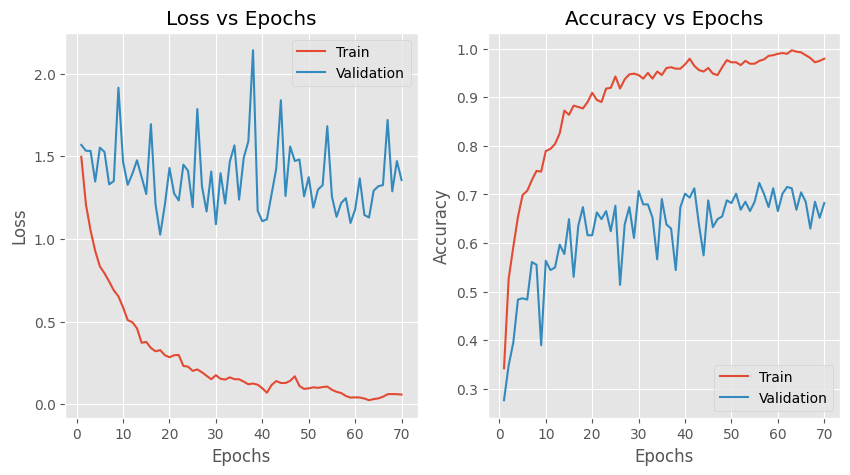

In [43]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()

Metrix for current model:
              precision    recall  f1-score   support

           0       0.72      0.71      0.72        55
           1       0.59      0.74      0.66        81
           2       0.73      0.90      0.81        69
           3       0.80      0.72      0.76        85
           4       0.89      0.56      0.68        72

    accuracy                           0.72       362
   macro avg       0.75      0.72      0.72       362
weighted avg       0.75      0.72      0.72       362

Accuracy: 0.7238


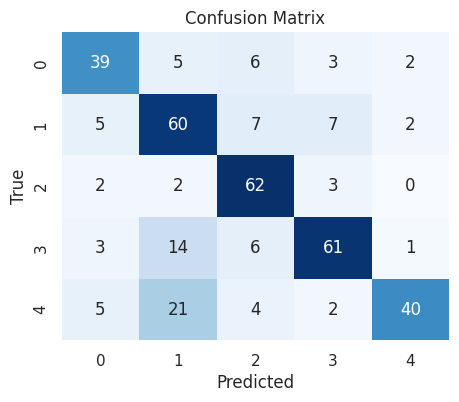

In [44]:
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)
cm, report, accuracy_2, weighted_f1_2=evaluate_model(model, val_loader)
print('Metrix for current model:')
print(report)
print(f'Accuracy: {accuracy_2:.4f}')
plot_confusion_matrix(cm, classes=list(range(5)))